In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, fmin_ncg
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [42]:
data = np.loadtxt('ds-boot-1.csv', delimiter='\t', skiprows=1)

## Part1. Fitting the model
$\text{First, G-O S-model was trained}
\\ 
\mu(t) = a(1-e^{-bt}(1+bt))$

Not being a typical target function, G-O involves some optimization problems. Those were worked around by using gradient descent twice, reducing the learning rate at the second step. Logarithmic cost function was used.

In [293]:
def s_shape_NM(tht, X):
    return 5500-5500*np.e**(-tht*X)*(1+tht*X)

def s_shape(tht, X):
    theta = tht.flatten()
    return theta[0]-theta[0]*np.e**(-theta[1]*X)*(1+theta[1]*X)
    #return 5500-5500*np.e**(-theta[1]*X)*(1+theta[1]*X)
    
def costJ_NM(theta, X, y):
    m = y.size
    y_loc = y #.reshape(m,1)
    predicted = s_shape_NM(theta, X)
    cost = ((predicted-y)**2).sum()/2/m
    return cost
    
def costJ(theta, X, y):
    m = y.size
    y_loc = y #.reshape(m,1)
    predicted = s_shape(theta, X)
    cost = ((predicted-y)**2).sum()/2/m
    return cost

def log_costJ(theta, X, y):
    m = y.size
    y_loc = y #.reshape(m,1)
    predicted = s_shape(theta, X)
    cost = np.mean((np.log(1+y) - np.log(1+predicted))**2)
    return cost

def gradJ(theta, X, y):
    theta_loc = theta.flatten()
    grad = np.empty(theta.size)
    a = theta_loc[0]
    b = theta_loc[1]
    grad[0] = ((1-np.e**(-b*X)*(1+b*X))*(s_shape(theta,X)-y)).sum()/m
    grad[1] = (a*X**2*b*np.e**(-b*X)*(s_shape(theta,X)-y)).sum()/m
    return grad

def log_gradJ(theta, X, y):
    theta_loc = theta.flatten()
    grad = np.empty(theta.size)
    a = theta_loc[0]
    term1 = np.log(1+y)-np.log(1+s_shape(theta_loc,X))
    term2 = -s_shape(theta_loc,X)/a/(1+s_shape(theta_loc,X))
    grad[0] = 2*np.mean(term1*term2)
    b = theta_loc[1]
    term3 = -1/(1+s_shape(theta_loc,X))
    term4 = a*b*X**2*np.e**(-b*X)
    grad[1] = 2*np.mean(term1*term3*term4)
#     print(term1)
#     print(term2)
#     print(term3)
#     print(term4)
    return grad

def grad_descent(cost_func, grad_func, x, y, theta_init, alpha1, alpha2, epsilon, max_iters=1500):
    n = theta_init.size
    theta = theta_init.copy()
    p_cost = cost_func(theta, x,y) + epsilon
#     print(p_cost)
    for i in range(max_iters):
        c_cost = cost_func(theta,x,y)
        if c_cost > p_cost - epsilon:
#             print('Convergence @ theta = {}'.format(theta))
#             print('Cost function value = {}'.format(c_cost))
#             print('Number of iterations: {}'.format(i))
            return theta
        grad = grad_func(theta,x,y)
        theta[0] = theta[0] - alpha1*grad[0]
        theta[1] = theta[1] - alpha2*grad[1]
        
#     print('Failed to converge')
#     print('Current theta = {}'.format(theta))
#     print('Cost function value = {}'.format(c_cost))
    return theta  

In [43]:
X = data[:,0]
y = data[:,2]
y_pred = s_shape(theta_init, X)

### Cost function versus b parameter. The chart illustrates non-convexity of the cost function

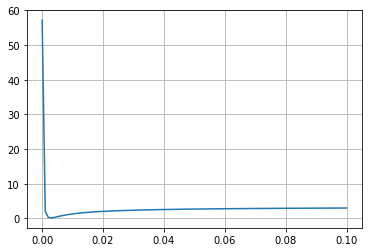

In [58]:
x = np.linspace(0,.1,100).reshape(100,1)
gr = np.insert(x,0,5000,axis=1)
grad = [log_costJ(x, data[:,0], data[:,2]) for x in gr]
plt.plot(x,grad)
plt.grid()
plt.show()

### One of the difficulties with optimisation was adequate initialisation of parameter values.

In [225]:
theta_init = np.array([60, .01])
m = data.shape[0]

In [166]:
result = fmin_cg(log_costJ, theta_init, fprime=log_gradJ, args=(data[:,0], data[:,2]), gtol=1e-100)
print(result)

         Current function value: 2.729987
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 55
[  5.38803356e+02   1.33570457e-02]


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in power
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in multiply
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/opt/anaconda3/lib/python3.6/site-packages/i

In [226]:
result = minimize(costJ_NM, 0.1, method='Nelder-Mead', args=(data[:,0], data[:,2]))
result = result.x
result = np.array([5500,result])
print(result)

[  5.50000000e+03   2.99032211e-03]


In [228]:
result = grad_descent(log_costJ, log_gradJ, X, y, theta_init, 50000, 1e-5, epsilon=1e-20, max_iters=50000)

13.7045034823
Failed to converge
Current theta = [[  4.63288312e+03]
 [  2.37948830e-03]]
Cost function value = 0.13182234818129002


In [229]:
result = grad_descent(log_costJ, log_gradJ, X, y, result, 500000, 1e-8, epsilon=1e-20, max_iters=5000)

0.165748520754
Failed to converge
Current theta = [[  7.58051120e+03]
 [  2.01586609e-03]]
Cost function value = 0.07464449362407696


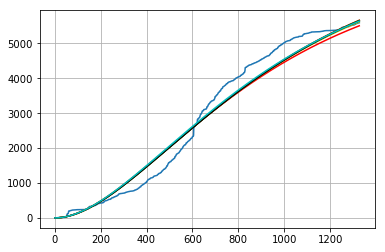

In [313]:
fig = plt.figure()

ax = plt.axes()
ax.grid()
ax.plot(data[:,0], data[:,2])
ax.plot(data[:,0], s_shape(result, data[:,0]), 'r')
ax.plot(data[:,0], s_shape(coefs[0], data[:,0]), 'r')
ax.plot(data[:,0], s_shape(coefs[250], data[:,0]), 'g')
ax.plot(data[:,0], s_shape(coefs[500], data[:,0]), 'y')
ax.plot(data[:,0], s_shape(coefs[750], data[:,0]), 'black')
ax.plot(data[:,0], s_shape(coefs[999], data[:,0]), 'c')

plt.show()

## Part 2

The procedure of fitting the model was repeated B=1000 times for each of the bootstrapped subsamples. The analysis of the parameters shows that their values sit closely together, which means that for a single instance of model fitting, the result almost does not depend on the period of execution time t, at which measures of the number of defects are taken. This result, however, does not allow to make any other judgement on the robustness of the model, such as whether it is suitable for different datasets etc.

In [296]:
B=1000

In [231]:
def create_B_sample_indices(dataset, B):
    m = dataset.shape[0]
    n = dataset.shape[1]
    result_indices = np.random.choice(m, (B,m))
    return result_indices

In [294]:
def train_B_regressions(dataset, B):
    indices_2d = create_B_sample_indices(dataset,B)
    m = dataset.shape[0]
    n = 2
    X = dataset[:,0]
    y = dataset[:,2]
    theta_init = np.array([60, .01])
    result = np.empty((B,n))
#     sigmas  = np.empty(B)
    i=0
    for line in indices_2d:
#         print(line)
#         print(dataset[line][:,1:-5].shape)
#         coefs = regr.coef_
#         print(coefs.shape)
#         result[i] = np.insert(coefs,0, regr.intercept_, axis=1)
        coefs = grad_descent(log_costJ, log_gradJ, X[line], y[line], theta_init, 50000, 1e-5, epsilon=1e-20, max_iters=50000)
        result[i] = grad_descent(log_costJ, log_gradJ, X[line], y[line], coefs, 500000, 1e-8, epsilon=1e-20, max_iters=5000)
#         sigmas[i] = np.std(regr.predict(dataset[line][:,1:-5])[:,1]-dataset[line][:,-4])
#         result = np.append(result, coefs)
        i += 1
#     return result, sigmas
    return result

In [303]:
def analyze_coefs(coefs):
#     for value in range(coefs.shape[1]):
#         print('Target {}:'.format(value))
    for feature_num in range(coefs.shape[1]):
        print('\tFeature {:d}:\n\t\t95%-Confidence interval: {:.3e} +/- {:.3e}\n\t\tRange: {:.3e} - {:.3e}\n\t\t% of outliers: {:.2f}\n\t\tNumber of outliers: {}'.format(
            feature_num+1, 
            coefs[:,feature_num].mean(),
            coefs[:,feature_num].std(),
            coefs[:,feature_num].min(), 
            coefs[:,feature_num].max(), 
            coefs[:,feature_num][(coefs[:,feature_num]>coefs[:,feature_num].mean()+3*coefs[:,feature_num].std()) | (coefs[:,feature_num]<coefs[:,feature_num].mean()-3*coefs[:,feature_num].std())].size  /B,
            coefs[:,feature_num][(coefs[:,feature_num]>coefs[:,feature_num].mean()+3*coefs[:,feature_num].std()) | (coefs[:,feature_num]<coefs[:,feature_num].mean()-3*coefs[:,feature_num].std())].size))

In [297]:
coefs = train_B_regressions(data, B)

In [304]:
analyze_coefs(coefs)

	Feature 1:
		95%-Confidence interval: 7.232e+03 +/- 4.079e+02
		Range: 6.091e+03 - 8.114e+03
		% of outliers: 0.00
		Number of outliers: 0
	Feature 2:
		95%-Confidence interval: 2.099e-03 +/- 1.044e-04
		Range: 1.888e-03 - 2.432e-03
		% of outliers: 0.00
		Number of outliers: 2


In [300]:
np.savetxt('coefs_task2.txt', coefs, delimiter=',')